In [1]:
import numpy as np
import matplotlib.pyplot as plt

from loguru import logger
from dataclasses import dataclass

from geogiant.analysis.plot import ecdf
from geogiant.common.files_utils import load_pickle, load_csv, load_json
from geogiant.common.ip_addresses_utils import get_prefix_from_ip
from geogiant.common.settings import PathSettings, ClickhouseSettings

path_settings = PathSettings()
clickhouse_settings = ClickhouseSettings()


@dataclass(frozen=True)
class ResultsScore:
    client_granularity: str
    answer_granularity: str
    scores: list
    inconsistent_mappings: list


targets = load_json(path_settings.OLD_TARGETS)
vps = load_json(path_settings.OLD_VPS)
vps_coordinates = {}
for vp in vps:
    vps_coordinates[vp["address_v4"]] = {
        "lat": vp["geometry"]["coordinates"][1],
        "lon": vp["geometry"]["coordinates"][0],
        "country_code": vp["country_code"],
    }

In [2]:
ecs_scores = load_pickle(
    path_settings.RESULTS_PATH / "score_not_extended_filtered_hostname_answer.pickle"
)

ecs_results = load_pickle(
    path_settings.RESULTS_PATH / "results_not_extended_filtered_hostname_subnet.pickle"
)

In [3]:
wrongful_geoloc = ecs_results["wrongful_geoloc"]

logger.info(f"{len(ecs_scores.scores)}")
inconsistent_mapping_subnet = [
    get_prefix_from_ip(t["address_v4"]) for t in ecs_scores.inconsistent_mappings
]

hostname_filter = load_csv(path_settings.DATASET / "valid_hostnames_cdn.csv")
hostname_filter = [row.split(",")[0] for row in hostname_filter]
hostname_filter = "".join([f",'{h}'" for h in hostname_filter])[1:]
hostname_filter = f"AND hostname IN ({hostname_filter})"

count = 0
for target_addr, target_results in wrongful_geoloc[50].items():
    diff_error = target_results["elected_d_error"] - target_results["best_d_error"]
    elected_lat, elected_lon, elected_country = (
        vps_coordinates[target_results["best_elected_vp"]]["lat"],
        vps_coordinates[target_results["best_elected_vp"]]["lon"],
        vps_coordinates[target_results["best_elected_vp"]]["country_code"],
    )
    best_lat, best_lon, best_country = (
        vps_coordinates[target_results["best_vp"]]["lat"],
        vps_coordinates[target_results["best_vp"]]["lon"],
        vps_coordinates[target_results["best_vp"]]["country_code"],
    )

    logger.info("######################################")
    logger.info(
        f"Inconsistent mapping: {True if target_results['target_subnet'] in inconsistent_mapping_subnet else False}"
    )
    logger.info(f"Target : {target_addr}")
    logger.info(f"Target BGP prefix : {target_results['target_bgp_prefix']}")
    logger.info(f"Traget Misallocation: {target_results['target_misallocation']}")
    logger.info("ECS-DNS elected VP:")
    logger.info(f"addr    = {target_results['best_elected_vp']}")
    logger.info(f"score   = {target_results['best_elected_vp_score']}")
    logger.info(f"index   = {target_results['best_elected_vp_index']}")
    logger.info(f"d error = {target_results['elected_d_error']}")
    logger.info(f"min rtt = {target_results['elected_min_rtt']}")
    logger.info(f"coordinates = {elected_lat},{elected_lon}")
    logger.info(f"country = {elected_country}")
    logger.info("Min RTT VP:")
    logger.info(f"addr    = {target_results['best_vp']}")
    logger.info(f"score   = {target_results['best_vp_score']}")
    logger.info(f"index   = {target_results['best_vp_index']}")
    logger.info(f"d error = {target_results['best_d_error']}")
    logger.info(f"min rtt = {target_results['best_min_rtt']}")
    logger.info(f"coordinates = {best_lat},{best_lon}")
    logger.info(f"country = {best_country}")
    logger.info(f"diff error dist: {diff_error}")
    logger.info(f"Number of VPs selected: {len(target_results['vp_selection'])}")
    logger.info(
        f"SELECT client_subnet, hostname, answer_subnet, answer_bgp_prefix, pop_ip_info_id, pop_city, pop_country, pop_continent from {clickhouse_settings.DATABASE}.{'old_dns_mapping_with_metadata'} where (client_subnet == toIPv4('{target_results['target_subnet']}') OR client_subnet == toIPv4('{get_prefix_from_ip(target_results['best_elected_vp'])}') OR client_subnet == toIPv4('{get_prefix_from_ip(target_results['best_vp'])}')) {hostname_filter} order by (hostname, client_subnet)"
    )
    logger.info("######################################")

    count += 1

logger.info(
    f"Number of IP address with wrongful geoloc: {count} ({round(count * 100 / len(targets), 1)} [%])"
)

2024-02-27 14:08:43.776 | INFO     | __main__:<module>:3 - 756


KeyError: 'best_elected_vp'

# ECS-DNS VP selection function of CDN

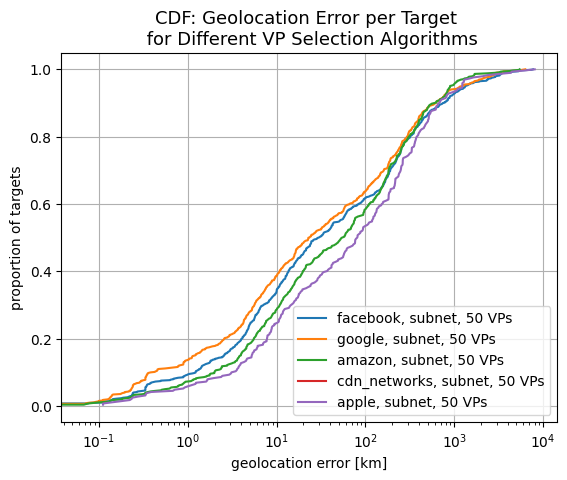

In [ ]:
cdn_results = load_pickle(path_settings.RESULTS_PATH / f"results_per_cdn.pickle")

fig, ax1 = plt.subplots(1, 1)

for cdn in cdn_results:
    for budget, target_results in cdn_results[cdn].items():
        if budget in [50]:
            x, y = ecdf([l["elected_d_error"] for l in target_results.values()])
            ax1.plot(x, y, label=f"{cdn}, subnet, {budget} VPs")

plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="lower right", fontsize=10)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation Error per Target \n for Different VP Selection Algorithms",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_all_vp_selection_algo.pdf")
plt.show()